In [16]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax import nnx
import optax
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from collections import defaultdict

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Summarizing the Connectivity patterns

We have the following:
1. rows and columns
2. cores
3. i/o slots
4. neighbors to all the cores
5. per slot there are neurons. Does that mean that the neurons only exist at the slots?

## Connectivity pattern
1. Cores that share a row and/or a column are connected. Tensor $C$ specifies these cores.
   1. e.g. $C[1, 1, 1, 2]$ represents if the cores present on row 1, col 1 and row 1, col 2 are connected. They are!
2. Each core has some number of neighbors. This number depends on perhaps where the core is located -- centrally located cored will have more neighbors.
   1. The tensor $N$ contains this info. It contains a linearly intexed list (0 to num_cores-1) and number of neighbors it has.
   2. e.g. $N[3, 2] = 2$ represents that there are $3$ cores with exactly $2$ neighbors.
3. The tensor $S$ determines how the cores can talk to each other. It describes how the slots are connected
   1. $S$ specifices how a core at a given row and column is connected to one of its neighbors through which i/o slots
   2. e.g. $S[1, 2, 3, 4, 1] = 1$ would imply that the core sitting at row 1, column 2, is connected to its neighbor #4, at the input slot #3 via its output slot #1 (verify this with Johannes). The 1 represents that such a connection exists.
4. Finally $W$ is the tensor containing all the weights. To find a weight between two neuron.

## Modules needed
1. Core module: with $256 \times 256$ weights.
2. Input Slot module: can accept a signed input vector. Each core should have 4 of these
3. Output slot module: vector - matrix multiplication ($64 \times 64$ weight $64 \times 1$ input vector) -- Not sure if this needs to be imp,emented explicitly!
4. Slot LUT module: For each input module, determine which core can send inputs.
5. External input module: Module that can provide external inputs to the cores. -- Does this need to be included in the Input Slot module

## Design
1. Make a module for the core. For every core initialize $256 \times 256$ weights. Each core should receive an input vector that is $256$ elements wide. This vector is stitched together from inputs from previous layer or external inputs.
2. Make a module

True False


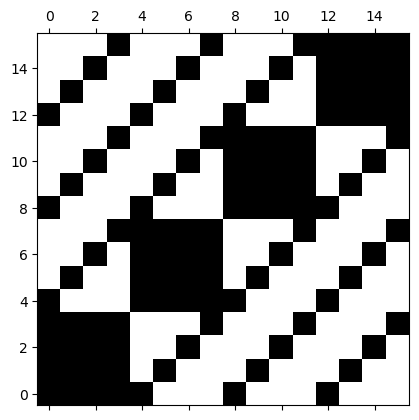

In [15]:
# which core is connected to which other core
num_rows = 4
num_cols = 4
num_slots_out = 2
num_slots_in  = 2
num_neighbors = 7
num_cores = num_rows * num_cols
num_neurons_per_slot = 8

# Connect cores -> baked into the hardware
# Define which cores can talk to which other cores (cores arranged in a grid)
C = jnp.zeros((num_rows, num_cols, num_rows, num_cols), dtype=bool)
# cores are connected along row busses
C = C.at[jnp.arange(num_rows), :, jnp.arange(num_rows), :].set(True)
# cores are connected along column busses
C = C.at[:, jnp.arange(num_cols), :, jnp.arange(num_cols)].set(True)
plt.matshow(C.reshape(num_cores, num_cores), cmap='gray_r', origin='lower')

print(C[1, 1, 1, 2], C[1, 1, 3, 2])

In [10]:
# Each core has a neighborhood of connected cores. In this neighborhood, each other core's output slots can be connected to input slots
assert jnp.allclose((C.sum(axis=(2, 3))), num_neighbors), f"Every core should have exactly {num_neighbors} neighbors"
# Find each core's neighbors
IDX = jnp.arange(num_cores).reshape(num_rows, num_cols)

# store which core (linearly indexed) has which neighbors (linearly indexed)
N = jnp.zeros((num_cores, num_neighbors), dtype=int)
N_one_hot = jnp.zeros((num_rows, num_cols, num_neighbors, num_rows, num_cols), dtype=bool)
for i in jnp.arange(num_rows):
    for j in jnp.arange(num_cols):
        nzs = jnp.nonzero(C[i,j,...], size=num_neighbors, fill_value=-1)
        # store the IDX of each neighbor (linearly indexed)
        N = N.at[IDX[i,j],:].set(IDX[*nzs])

        # store the one-hot encoding of each neighbor
        N_one_hot = N_one_hot.at[i,j,jnp.arange(num_neighbors),*nzs].set(True)
N, N_one_hot.shape

(Array([[ 0,  1,  2,  3,  4,  8, 12],
        [ 0,  1,  2,  3,  5,  9, 13],
        [ 0,  1,  2,  3,  6, 10, 14],
        [ 0,  1,  2,  3,  7, 11, 15],
        [ 0,  4,  5,  6,  7,  8, 12],
        [ 1,  4,  5,  6,  7,  9, 13],
        [ 2,  4,  5,  6,  7, 10, 14],
        [ 3,  4,  5,  6,  7, 11, 15],
        [ 0,  4,  8,  9, 10, 11, 12],
        [ 1,  5,  8,  9, 10, 11, 13],
        [ 2,  6,  8,  9, 10, 11, 14],
        [ 3,  7,  8,  9, 10, 11, 15],
        [ 0,  4,  8, 12, 13, 14, 15],
        [ 1,  5,  9, 12, 13, 14, 15],
        [ 2,  6, 10, 12, 13, 14, 15],
        [ 3,  7, 11, 12, 13, 14, 15]], dtype=int32),
 (4, 4, 7, 4, 4))

In [11]:
# Connect slots -> configured by the LUTs
S = jax.random.randint(jax.random.PRNGKey(0), (num_rows, num_cols, num_slots_in, num_neighbors, num_slots_out), 0, 2).astype(bool)
# Compute how all slots are connected
S_flat = jnp.einsum("ijmn,ijqmn,ijkqo->ijkmno", C, N_one_hot, S)

# Define weights -> stored in RRAM
# Each cores slots are connected to other cores slots with a weight matrix
W = jax.random.normal(jax.random.PRNGKey(0), (num_rows, num_cols, num_slots_in, num_neurons_per_slot, num_slots_out, num_neurons_per_slot))
# Compute how all weights are connected
W_flat = jnp.einsum("ijkmno,ijklop->ijklmnop", S_flat, W)

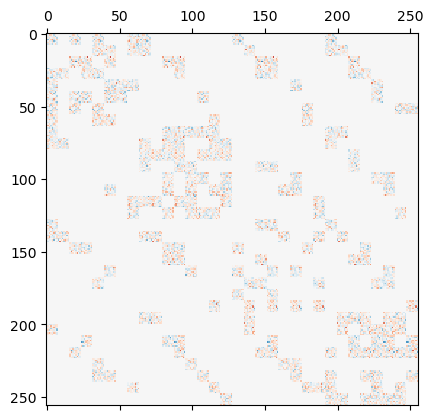

In [12]:
num_neurons_total = num_cores * num_slots_out * num_neurons_per_slot
plt.matshow(W_flat.reshape(num_neurons_total, num_neurons_total)[:10000,:10000], cmap='RdBu_r', vmin=-6, vmax=6)